In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# For handling Excel files
import openpyxl
# For progress bars
from tqdm.notebook import tqdm
# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline
import glob
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [2]:
import os
import shutil

# Define the path to the original dataset directory
original_dataset_dir = "E:/NSU/sem 9/MDY Research/Leukemia dataset/img"  # Change this if needed

# Define a writable output directory for the new folders
output_dir = "E:/NSU/sem 9/MDY Research/Leukemia dataset/output_dir"  # Writable directory for new dataset
os.makedirs(output_dir, exist_ok=True)

# Define paths for the new class folders
healthy_dir = os.path.join(output_dir, 'healthy')
blast_dir = os.path.join(output_dir, 'blast')

# Create the new folders in the writable directory
os.makedirs(healthy_dir, exist_ok=True)
os.makedirs(blast_dir, exist_ok=True)

# Iterate over each file in the original dataset directory
for filename in os.listdir(original_dataset_dir):
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.tif'):
        # Check the last digit after the underscore to determine the label
        label = filename.split('_')[1][0]
        
        # Move file to the appropriate folder based on label
        source_path = os.path.join(original_dataset_dir, filename)
        if label == '0':
            shutil.copy(source_path, os.path.join(healthy_dir, filename))  # Copy to healthy folder
        elif label == '1':
            shutil.copy(source_path, os.path.join(blast_dir, filename))  # Copy to blast folder

print("Files have been separated into 'healthy' and 'blast' folders in the output directory.")


Files have been separated into 'healthy' and 'blast' folders in the output directory.


In [3]:
class ALLIDB2Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the directory with subdirectories for each class (healthy, blast).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        # Walk through each subdirectory and add file paths and labels
        for label, sub_dir in enumerate(['healthy', 'blast']):  # 0 for healthy, 1 for blast
            class_dir = os.path.join(root_dir, sub_dir)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_files.append(img_path)
                self.labels.append(label)  # Label based on folder name

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]
        
        # Load image and convert to RGB
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
from torchvision import transforms

# Define transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to the input size expected by ResNet50
    transforms.RandomHorizontalFlip(),       # Data augmentation
    transforms.RandomRotation(15),           # Rotate to add variety
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # More augmentation
    transforms.ToTensor(),                   # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize based on ImageNet stats
])

# Define transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to input size expected by ResNet50
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet stats
])



In [5]:
from torch.utils.data import DataLoader, random_split

# Root directory where 'healthy' and 'blast' folders are stored
dataset_root_dir = "E:/NSU/sem 9/MDY Research/Leukemia dataset/output_dir"

# Initialize the full dataset (no transform at this stage, as we will apply specific transforms per split)
full_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

# Apply transformations to each dataset
train_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=train_transform)
val_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=val_test_transform)
test_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=val_test_transform)

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")



Train size: 182, Val size: 39, Test size: 39


In [6]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2, self).__init__()
        
        # Load MobileNetV2 without ImageNet weights (pretrained=False)
        self.model = models.mobilenet_v2(weights=None)
        
        # Replace the classifier with the number of classes you need
        self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)
    
    def forward(self, x):
        return self.model(x)

## ECA Block

In [8]:
import torch.nn as nn
import torch.fft 

class FrequencyChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(FrequencyChannelAttention, self).__init__()
        self.channels = channels
        self.reduction = reduction
        
        # Squeeze operation in frequency domain
        self.squeeze = nn.Conv2d(channels, channels // reduction, kernel_size=1)
        self.excitation = nn.Conv2d(channels // reduction, channels, kernel_size=1)
        
    def forward(self, x):
        # Apply DCT along spatial dimensions to get frequency representation
        freq = torch.fft.fft2(x, norm="ortho")
        
        # Take the magnitude of the frequency representation
        freq_magnitude = torch.abs(freq)
        
        # Squeeze and Excitation in frequency domain
        squeezed = self.squeeze(freq_magnitude)
        activated = torch.relu(squeezed)
        excited = self.excitation(activated)
        
        # Apply a sigmoid to get channel-wise attention weights
        attention = torch.sigmoid(excited)
        
        # Apply attention weights to original input
        x = x * attention
        
        return x

In [9]:
import torch.nn as nn
import torchvision.models as models

class MobileNetV2WithFCA(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2WithFCA, self).__init__()
        
        # Load MobileNetV2 without pre-trained weights
        self.mobilenet = models.mobilenet_v2(weights=None)
        
        # Get the number of output channels from the last convolutional layer
        bottleneck_channels = self.mobilenet.last_channel
        
        # Define an FCA block to match the bottleneck output channels
        self.fca = FrequencyChannelAttention(channels=bottleneck_channels)
        
        # Replace the classifier with a new one for the specified number of classes
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(bottleneck_channels, num_classes)
        )
    
    def forward(self, x):
        # Forward pass through MobileNetV2 feature extractor
        x = self.mobilenet.features(x)
        
        # Apply FCA block after bottleneck
        x = self.fca(x)
        
        # Global average pooling
        x = x.mean([2, 3])  # Equivalent to nn.AdaptiveAvgPool2d((1, 1)) and flatten
        
        # Forward pass through the classifier
        x = self.mobilenet.classifier(x)
        
        return x


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model for binary or multi-class classification
num_classes = 2  # Modify based on your dataset (e.g., 2 for binary classification, 4 for multi-class)
model = MobileNetV2WithFCA(num_classes=num_classes)  # For RGB images

# Move the model to the GPU (or CPU if GPU is not available)
model.to(device)

# Check model architecture
print(model)

MobileNetV2WithFCA(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kerne

In [11]:
from sklearn.utils.class_weight import compute_class_weight
# Extract labels from training data
# Compute class weights
train_labels = [sample[1] for sample in train_data]
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")

Class Weights: tensor([1.0225, 0.9785])


In [12]:
# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device='cuda'):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = None
    
    print(f"Using device: {device}")
    
    # Move model to the correct device
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 30)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
                # Move data to the correct device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # Scheduler step
            if phase == 'train':
                scheduler.step()
            
            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            
            # Check if this is the best model so far in validation phase
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
        
        print(f"End of Epoch {epoch + 1}: Train Loss - {history['train_loss'][-1]:.4f}, "
              f"Val Loss - {history['val_loss'][-1]:.4f}")
    
    print(f'\nTraining complete. Best Validation Accuracy: {best_acc:.4f}')
    
    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    
    return model, history

# Define number of epochs
num_epochs = 25

# Ensure you have set the device correctly (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming model, criterion, optimizer, scheduler, train_loader, and val_loader are defined properly

trained_model, history = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device=device
)


Using device: cuda
Using device: cuda

Epoch 1/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s]


Train Loss: 0.6351, Accuracy: 0.6462


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 20.33it/s]


Val Loss: 0.9817, Accuracy: 0.5000
End of Epoch 1: Train Loss - 0.6351, Val Loss - 0.9817

Epoch 2/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]


Train Loss: 0.5526, Accuracy: 0.7077


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 18.61it/s]


Val Loss: 0.9638, Accuracy: 0.5000
End of Epoch 2: Train Loss - 0.5526, Val Loss - 0.9638

Epoch 3/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  5.12it/s]


Train Loss: 0.4992, Accuracy: 0.7538


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 18.97it/s]


Val Loss: 1.4009, Accuracy: 0.5000
End of Epoch 3: Train Loss - 0.4992, Val Loss - 1.4009

Epoch 4/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]


Train Loss: 0.4274, Accuracy: 0.8077


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 18.34it/s]


Val Loss: 1.2022, Accuracy: 0.5192
End of Epoch 4: Train Loss - 0.4274, Val Loss - 1.2022

Epoch 5/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  5.41it/s]


Train Loss: 0.4312, Accuracy: 0.7615


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 17.21it/s]


Val Loss: 0.3338, Accuracy: 0.8577
End of Epoch 5: Train Loss - 0.4312, Val Loss - 0.3338

Epoch 6/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  5.13it/s]


Train Loss: 0.4461, Accuracy: 0.7923


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 18.24it/s]


Val Loss: 0.4146, Accuracy: 0.8731
End of Epoch 6: Train Loss - 0.4461, Val Loss - 0.4146

Epoch 7/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  5.03it/s]


Train Loss: 0.3345, Accuracy: 0.8692


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 17.29it/s]


Val Loss: 0.1923, Accuracy: 0.9192
End of Epoch 7: Train Loss - 0.3345, Val Loss - 0.1923

Epoch 8/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.87it/s]


Train Loss: 0.3778, Accuracy: 0.8154


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 18.18it/s]


Val Loss: 0.3015, Accuracy: 0.8269
End of Epoch 8: Train Loss - 0.3778, Val Loss - 0.3015

Epoch 9/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.87it/s]


Train Loss: 0.3648, Accuracy: 0.8385


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 17.38it/s]


Val Loss: 0.1891, Accuracy: 0.9192
End of Epoch 9: Train Loss - 0.3648, Val Loss - 0.1891

Epoch 10/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.97it/s]


Train Loss: 0.3207, Accuracy: 0.8731


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 17.76it/s]


Val Loss: 0.1850, Accuracy: 0.9346
End of Epoch 10: Train Loss - 0.3207, Val Loss - 0.1850

Epoch 11/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.94it/s]


Train Loss: 0.3318, Accuracy: 0.8615


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 17.51it/s]


Val Loss: 0.1404, Accuracy: 0.9423
End of Epoch 11: Train Loss - 0.3318, Val Loss - 0.1404

Epoch 12/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.89it/s]


Train Loss: 0.3308, Accuracy: 0.8808


Val Phase: 100%|██████████| 17/17 [00:01<00:00, 16.77it/s]


Val Loss: 0.1521, Accuracy: 0.9462
End of Epoch 12: Train Loss - 0.3308, Val Loss - 0.1521

Epoch 13/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.76it/s]


Train Loss: 0.2314, Accuracy: 0.8808


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 17.34it/s]


Val Loss: 0.1273, Accuracy: 0.9615
End of Epoch 13: Train Loss - 0.2314, Val Loss - 0.1273

Epoch 14/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.87it/s]


Train Loss: 0.2645, Accuracy: 0.8885


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 18.33it/s]


Val Loss: 0.1161, Accuracy: 0.9538
End of Epoch 14: Train Loss - 0.2645, Val Loss - 0.1161

Epoch 15/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  5.04it/s]


Train Loss: 0.2452, Accuracy: 0.9192


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 17.41it/s]


Val Loss: 0.1148, Accuracy: 0.9538
End of Epoch 15: Train Loss - 0.2452, Val Loss - 0.1148

Epoch 16/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.97it/s]


Train Loss: 0.2081, Accuracy: 0.9346


Val Phase: 100%|██████████| 17/17 [00:01<00:00, 16.74it/s]


Val Loss: 0.1085, Accuracy: 0.9615
End of Epoch 16: Train Loss - 0.2081, Val Loss - 0.1085

Epoch 17/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.81it/s]


Train Loss: 0.2158, Accuracy: 0.9154


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 17.33it/s]


Val Loss: 0.1169, Accuracy: 0.9577
End of Epoch 17: Train Loss - 0.2158, Val Loss - 0.1169

Epoch 18/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.86it/s]


Train Loss: 0.2446, Accuracy: 0.9115


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 17.96it/s]


Val Loss: 0.1271, Accuracy: 0.9615
End of Epoch 18: Train Loss - 0.2446, Val Loss - 0.1271

Epoch 19/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  5.01it/s]


Train Loss: 0.2436, Accuracy: 0.9269


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 17.56it/s]


Val Loss: 0.1248, Accuracy: 0.9615
End of Epoch 19: Train Loss - 0.2436, Val Loss - 0.1248

Epoch 20/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.86it/s]


Train Loss: 0.2679, Accuracy: 0.9077


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 18.32it/s]


Val Loss: 0.1507, Accuracy: 0.9538
End of Epoch 20: Train Loss - 0.2679, Val Loss - 0.1507

Epoch 21/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  5.10it/s]


Train Loss: 0.2861, Accuracy: 0.8923


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 18.38it/s]


Val Loss: 0.1281, Accuracy: 0.9577
End of Epoch 21: Train Loss - 0.2861, Val Loss - 0.1281

Epoch 22/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  5.12it/s]


Train Loss: 0.2134, Accuracy: 0.9192


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 17.92it/s]


Val Loss: 0.1229, Accuracy: 0.9538
End of Epoch 22: Train Loss - 0.2134, Val Loss - 0.1229

Epoch 23/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.94it/s]


Train Loss: 0.2296, Accuracy: 0.9269


Val Phase: 100%|██████████| 17/17 [00:01<00:00, 16.98it/s]


Val Loss: 0.1191, Accuracy: 0.9538
End of Epoch 23: Train Loss - 0.2296, Val Loss - 0.1191

Epoch 24/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.75it/s]


Train Loss: 0.2302, Accuracy: 0.9000


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 17.76it/s]


Val Loss: 0.1296, Accuracy: 0.9615
End of Epoch 24: Train Loss - 0.2302, Val Loss - 0.1296

Epoch 25/25
------------------------------


Train Phase: 100%|██████████| 17/17 [00:03<00:00,  4.88it/s]


Train Loss: 0.1931, Accuracy: 0.9154


Val Phase: 100%|██████████| 17/17 [00:00<00:00, 17.16it/s]

Val Loss: 0.1224, Accuracy: 0.9577
End of Epoch 25: Train Loss - 0.1931, Val Loss - 0.1224

Training complete. Best Validation Accuracy: 0.9615


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

classes = ['healthy', 'blast']

def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Testing: 100%|██████████| 17/17 [00:00<00:00, 17.34it/s]


Classification Report:
              precision    recall  f1-score   support

     healthy       0.93      0.98      0.96       130
       blast       0.98      0.93      0.96       130

    accuracy                           0.96       260
   macro avg       0.96      0.96      0.96       260
weighted avg       0.96      0.96      0.96       260



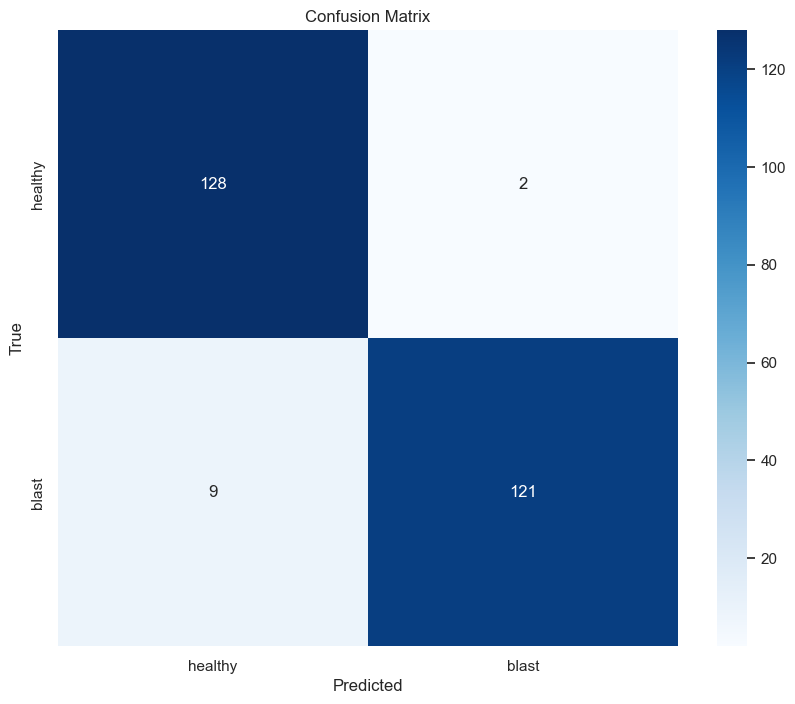

In [15]:
# Evaluate the model on the test set
evaluate_model(trained_model, test_loader, classes)

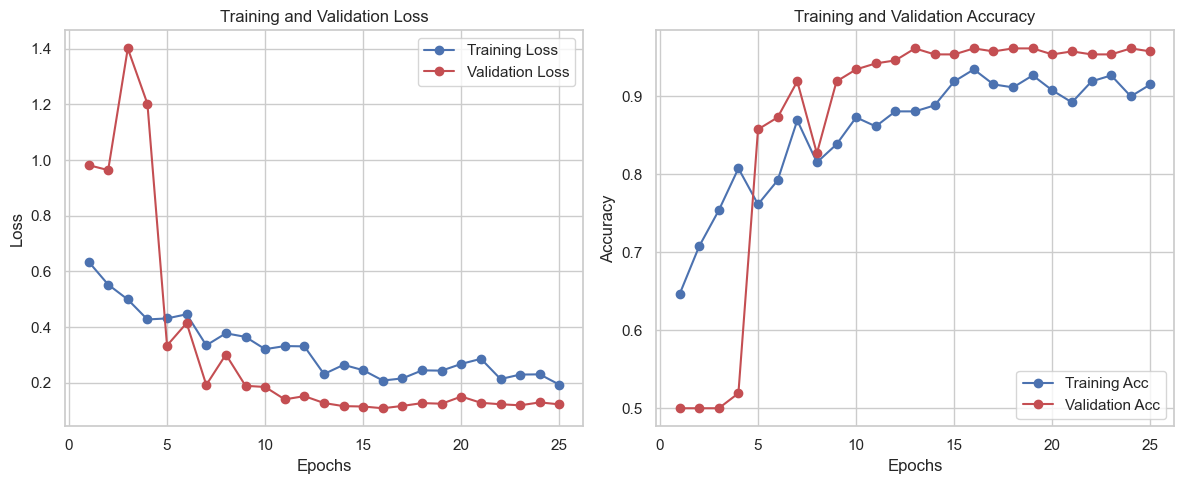

In [16]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)

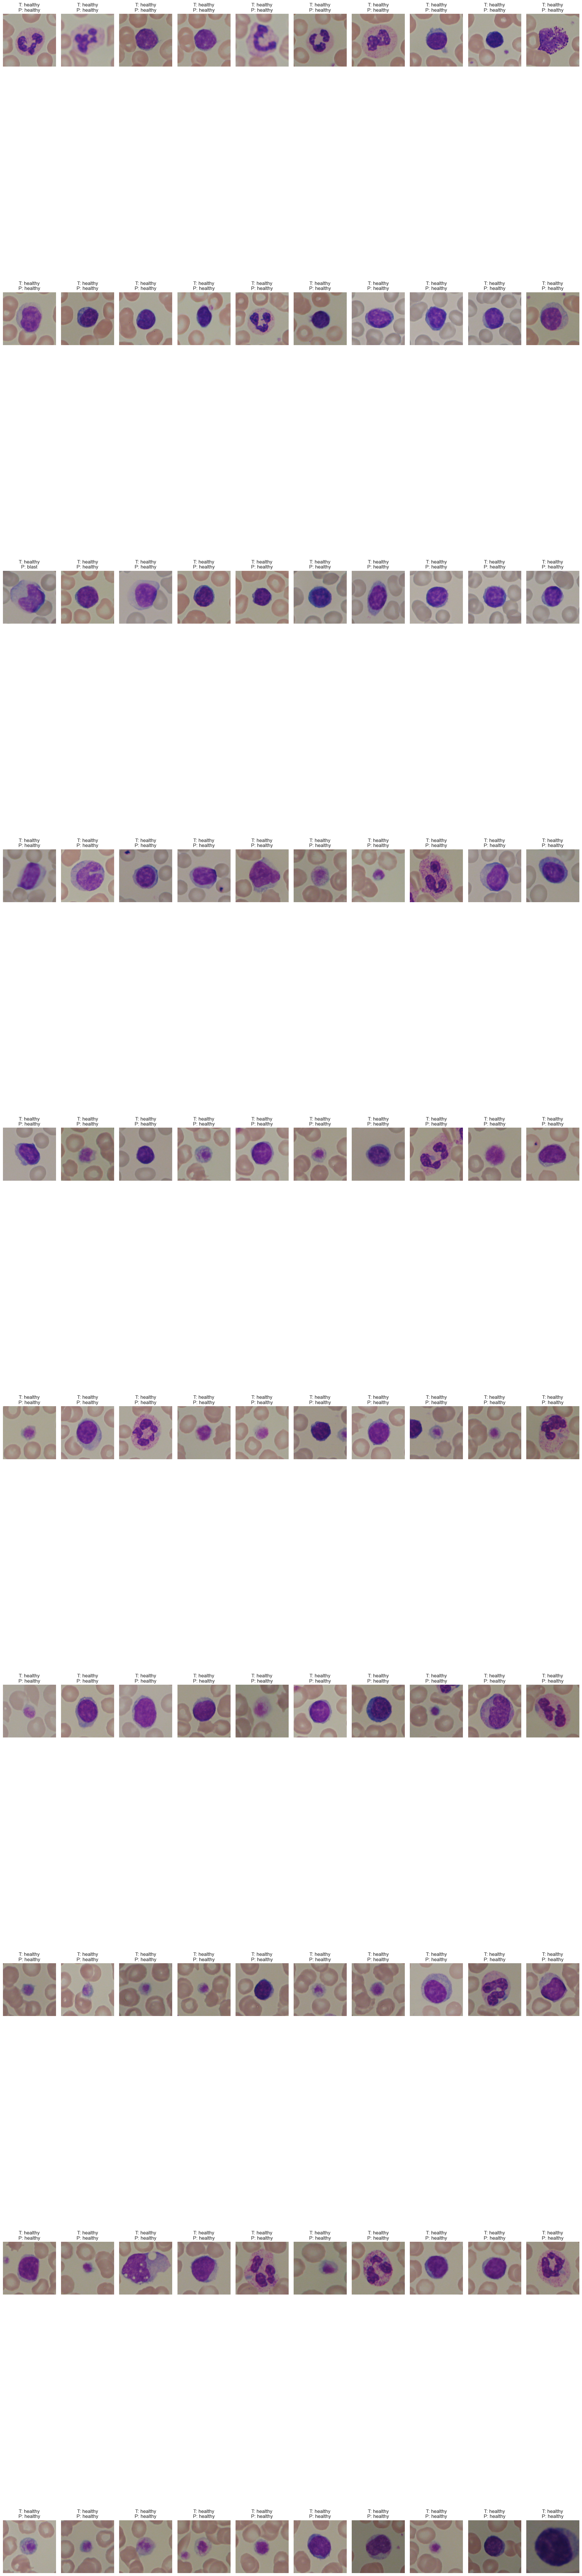

In [17]:
import random

def visualize_random_100_predictions(model, dataloader, classes, num_images=100):
    model.eval()
    collected_images, collected_labels, collected_preds = [], [], []
    
    with torch.no_grad():
        # Loop over the dataset and randomly sample images until we collect 100
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Move tensors to CPU for numpy conversion
            images = images.cpu().numpy()
            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()
            
            # Select a random subset of images from the batch if needed
            indices = list(range(images.shape[0]))
            random.shuffle(indices)
            for idx in indices:
                if len(collected_images) < num_images:
                    collected_images.append(images[idx])
                    collected_labels.append(labels[idx])
                    collected_preds.append(preds[idx])
                else:
                    break
            if len(collected_images) >= num_images:
                break  # Stop once we have 100 images

    # Plot the 100 random images with true and predicted labels
    plt.figure(figsize=(20, 100))  # Adjust figure size for better viewing
    for i in range(num_images):
        plt.subplot(num_images // 10, 10, i + 1)
        
        # Display the image
        img = collected_images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"T: {classes[collected_labels[i]]}\nP: {classes[collected_preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 100 random sample predictions
visualize_random_100_predictions(trained_model, test_loader, classes, num_images=100)
